In [72]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
%matplotlib inline

In [58]:
# Read Images
img1, img2, img3 = cv2.imread("../data/nevada3.jpg"), cv2.imread("../data/nevada4.jpg"), cv2.imread("../data/nevada5.jpg")

In [60]:
sift = cv2.xfeatures2d.SIFT_create()

In [61]:
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
kp3, des3 = sift.detectAndCompute(img3, None)

In [62]:
def plot_key_points(img, keypoints):
    """
    Input - 
            img - Source image
            keypoints - Keypoints of above image
    Returns - None
    
    Plot image by convert to color.
    """
    image_to_plot = cv2.drawKeypoints(img, keypoints, np.array([]))
    plt.rcParams["figure.figsize"] = [20, 20]
    plt.imshow(cv2.cvtColor(image_to_plot, cv2.COLOR_BGR2RGB))

In [66]:
def get_homography(point_group_1, point_group_2, verbose=False):
    """
    Input - 2 groups of points chosen randomly
             as a part of RANSAC
    Returns - Homography matrix
    """
    
    # Init P as None
    P = None
    
    # P matrix
    for point1, point2 in zip(point_group_1, point_group_2):
        # Get x, y & x', y'
        x, y = point1[0], point1[1]
        x_bar, y_bar = point2[0], point2[1]
        
        point_matrix = [
            [x, y, 1, 0, 0, 0, -x * x_bar, -y * x_bar, -x_bar],
            [0, 0, 0, x, y, 1, -x * y_bar, -y * y_bar, -y_bar]
        ]
        # If this is the first pair of rows
        if P is None:
            P = np.array(point_matrix)
        # Or stack to exitsting
        else:
            P = np.vstack((P, point_matrix))
    
    # Get eigenvalues & eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(P.T.dot(P))
    
    # Get minimum eigenvalue's index
    min_eigenvalue_index = np.argmin(eigenvalues)
    
    # Sanity check - 1
    if verbose:
        print("Minimum eigenvalue found at ", min_eigenvalue_index, ":", eigenvalues[min_eigenvalue_index])
    
    # Get corresponding eigenvector
    min_eigenvector = eigenvectors[:, min_eigenvalue_index]
    
    # Normalize the eigenvector by L2 norm
    norm = np.linalg.norm(min_eigenvector)
    min_eigenvector /= norm
    
    # Sanity check - 2 
    # These values must be close to 0
    if verbose:
        print ("These values should be close to 0", np.round(P.dot(min_eigenvector), 2))
    
    # Homography matrix
    H = min_eigenvector.reshape(3, 3)
    
    # Sanity check - 3
    if verbose:
        for i, point in enumerate(point_group_1):
            point = [point[0], point[1], 1]
            point_2_predicted = np.dot(H, point)
            point_2_predicted = (point_2_predicted / point_2_predicted[-1])[:2]
                print("Original point:", point[:-1])
                print("Predicted point:", point_2_predicted)
                print("Actual point:", point_group_2[i])
                print()
    
    return H

In [67]:
point_group_1 = [[100, 500], [31, 18], [15, 6]]
point_group_2 = [[10, 20], [20, 50], [10, 90]]

get_homography(point_group_1, point_group_2)

array([[-0.15959955,  0.42287866, -0.04314394],
       [-0.27423201,  0.83660115, -0.00491378],
       [-0.02536449,  0.04390606,  0.1270445 ]])

In [472]:
# Matcher - based on descriptors
def one_NN_matcher(des1, des2):
    """
    Input - 
            des1 & des2 - Descriptor matrices for 2 images
            k - Number of nearest neighbors to consider
    Returns - A vector of nearest neighbors of des1 & their indices for keypoints
    
    Mnemonic - des1 is like xtest, des2 is like xtrain
    """

    # Compute the L2 equations
    distances = np.sum(des1 ** 2, axis=1, keepdims=True) + np.sum(des2 ** 2, axis=1) - 2 * des1.dot(des2.T)
    distances = np.sqrt(distances)
    
    
    # Get smallest indices 
    min_indices = np.argmin(distances, axis=1)
    
    # Init ndarray 
    nearest_neighbors = []
    
    # Iter for nearest neighbors
    for i in range(min_indices.shape[0]):
        match = cv2.DMatch(i, min_indices[i], 0, distances[i][min_indices[i]] * 1.)
        nearest_neighbors.append(match)
    
    return nearest_neighbors

In [473]:
matches = one_NN_matcher(des2, des3)

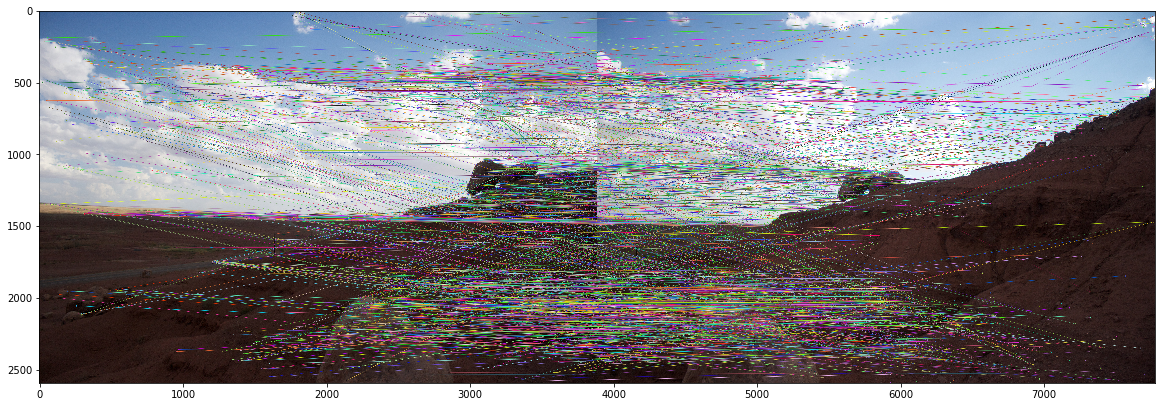

In [474]:
plt.imshow(cv2.cvtColor(cv2.drawMatches(img2, kp2, img3, kp3, matches, np.array([])), cv2.COLOR_RGBA2BGR))

In [600]:
def ransac(matches, kp1, kp2, epsilon=5.0, batch_size=4, max_iter=100):
    """
    Input - Matches from one_NN_matcher(..)
    Returns - Inlier homography matrix
    """    
    
    # Store best homography 
    best_H = None
    best_inilier_count = -1
        
    for curr_iter in range(max_iter):
        if (curr_iter + 1) % 5 == 0:
            print("Currently at iter #", (curr_iter +  1), sep="")
            
        # Randomly permute matches list
        np.random.shuffle(matches)
        
        # Iter through remaining matches
        for i in range(0, len(matches), batch_size):
            
            # Default termination condition
            if i + batch_size >= len(matches):
                break

            # Current random subsample
            point_group_1, point_group_2 = [], []
            for match in matches[i : i + batch_size]:
                point_group_1.append(kp1[match.queryIdx].pt)
                point_group_2.append(kp2[match.trainIdx].pt)


            # Compute Homography
            H = get_homography(point_group_1, point_group_2)

            # Initialize inlier Count
            inlier_count = 0


            # Add inliers; remove outliers
            for m in matches:
                # Get left point
                point_1 = [kp1[m.queryIdx].pt[0], kp1[m.queryIdx].pt[1], 1]
                
                # Get actual right point
                point_2_actual = [kp2[m.trainIdx].pt[0], kp2[m.trainIdx].pt[1]]

                # Predict right point
                point_2_predicted = np.dot(H, point_1)
                point_2_predicted = (point_2_predicted / point_2_predicted[-1])
                point_2_predicted = point_2_predicted[:-1]
                
                # Compute the L2 distances between predicted & actual point 
                diff = np.linalg.norm(np.subtract(point_2_actual, point_2_predicted))

                # Increment inlier_count if necessary
                if diff < epsilon:
                    inlier_count += 1

            # Update best model if necessary
            if inlier_count > best_inilier_count:
                best_inilier_count = inlier_count
                best_H = H
                
                # Terminate early based on count
                if best_inilier_count > int(0.3 * len(kp1)):
                    print("-------------------\nCutting short early\n-------------------")
                    # Print stats and return best_H
                    print("Inliers -", best_inilier_count)
                    print("Outliers -", len(kp1) - best_inilier_count)
                    return best_H
                    
    # Terminate normally with best_H seen
    print("Inliers -", best_inilier_count)
    print("Outliers -", len(kp1) - best_inilier_count)
    return best_H


In [605]:
matches = one_NN_matcher(des2, des3)
H = ransac(matches, kp2, kp3, epsilon=3.00, batch_size=4, max_iter=10)
H = H / H[-1, -1]

Currently at iter # 5
Currently at iter # 10
Inliers - 213
Outliers - 1290


In [606]:
H

[[ 1.43868731e+00 -4.04128146e-02 -2.01787124e+03]
 [ 1.66410921e-01  1.27806577e+00 -3.82752950e+02]
 [ 1.09406426e-04 -1.10418625e-06  1.00000000e+00]]


In [607]:
src = [kp2[m.queryIdx].pt for m in matches]
dst = [kp3[m.trainIdx].pt for m in matches]

src, dst = np.array(src), np.array(dst)

H, mask = cv2.findHomography(src, dst, cv2.RANSAC, 3.)
print(H)

[[ 1.38042067e+00 -6.19768050e-02 -1.87027236e+03]
 [ 1.58491428e-01  1.24949479e+00 -3.66276508e+02]
 [ 9.94350752e-05 -3.56185214e-06  1.00000000e+00]]
